# Higgs Challenge Example
In this part we will look at the **[Higgs Boson ML Challenge](https://www.kaggle.com/c/Higgs-boson)** on Kaggle and attempt a solution using Boosted Decision Trees (BDTs), a popular method in experimental particle physics. BDTs are based on an ensamble of weak classifiers (decision trees), and boosting increases the weight of misclassified events. Tomorrow, I will leave it as an excercise to try to get a solution using a neural network. The data is available from **[CERN Open Data](http://opendata.cern.ch/record/328)**. More information about the data is available from the links, and in particular at **[Documentation](http://opendata.cern.ch/record/329/files/atlas-higgs-challenge-2014.pdf)**. The general idea is that we want to extract $H\to\tau\tau$ signal from background. In particular, the selection requires one of the taus to decay into an electron or muon and two neutrinos, and the other into hadrons and a neutrino. The challenge is based on Monte Carlo events processed through the **[ATLAS detector](http://atlas.cern/)** simulation and reconstruction.


In [1]:
# the usual setup: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load training data
df = pd.read_csv('data/atlas-higgs-challenge-2014-v2.csv.gz')

In [3]:
df.iloc[:5]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


There is more information about the variables in the documentation. The variables that start with **DER** are derived quantities, determined by the physicists performing the analysis as variables that discriminate signal from backround. On the other hand, those that start with **PRI** are considered to be primary variables, from which the derived variables are calculated. They themselves generally do not provide much discrimination, but one if the ideas suggested by deep networks is that they can determine the necessary features from the primary variables, potentially even finding variables that the physicists did not consider. *EventId* identifies the event but is not a "feature." The *Weight* is the event weight so that the sum of weights of all signal events should produce the signal yield expected to be observed in 2012, and the sum of weights of all background events should produce the backgroudn yield. Note that the weight varies event to event, because different background and signal processes contribute to the background and signal sets. *Label* indicates if it is a signal or background event. Ignore the *Kaggle* variables--they are only used if you want to reproduce exactly what was used in the Challenge. 

One can use seaborn or other plotting packages to get a feel for the variables.

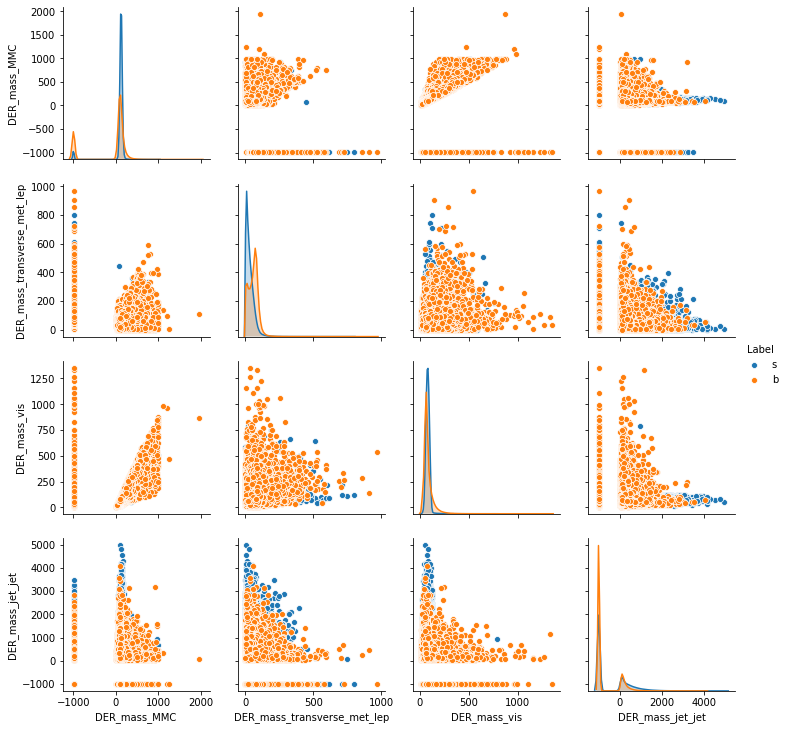

In [4]:
import seaborn as sns
sns.pairplot(df, vars=['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_mass_jet_jet'], hue='Label')

In [5]:
# map y values to integers
df['Label'] = df['Label'].map({'b':0, 's':1})


In [6]:
df.iloc[:5]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,1,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,0,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,0,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,0,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,0,t,6.245333


In [7]:
# let's create separate arrays
eventID = df['EventId']
X = df.loc[:,'DER_mass_MMC':'PRI_jet_all_pt']
y = df['Label']
weight = df['Weight']

In [8]:
#now split into testing and training samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, eventID_train, event_ID_test, weight_train, weight_test = train_test_split(
    X, y, eventID, weight, test_size=0.33, random_state=42)

In [9]:
# now let's define the model
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=50, max_depth=10,
                                    min_samples_leaf=200,
                                    max_features=10, verbose=1)


In [10]:
# and train
gbc.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2023            4.75m
         2           1.1334            4.71m
         3           1.0750            4.62m
         4           1.0265            4.72m
         5           0.9858            4.71m
         6           0.9511            4.58m
         7           0.9212            4.44m
         8           0.8951            4.32m
         9           0.8725            4.19m
        10           0.8531            4.06m
        20           0.7435            3.08m
        30           0.7037            2.10m
        40           0.6834            1.03m
        50           0.6714            0.00s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=10, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=200, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [11]:
gbc.score(X_test, y_test)

0.8425666341998156

As an aside, let's look at logistic regression. This is a very simple, linear model. In the exercises you can look at optimizing it a bit more.

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
lr = LogisticRegression(solver='liblinear')

In [14]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
lr.score(X_test,y_test)

0.7506286594647044

In [16]:
# Let's try using fewer features
lr2 = LogisticRegression(solver='liblinear')

In [17]:
lr2.fit(X_train.loc[:,:'DER_pt_tot'], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
lr2.score(X_test.loc[:,:'DER_pt_tot'], y_test)

0.7176494987389777

Let's get back to the original problem using the GradientBoostingClassifier. The Kaggle competition used the approximate median segnificance (AMS), as defined below, to determine how good a solution was. The number 10, added to the background yield, is a regularization term to decrease the variance of the AMS.

Note that if you do not use the full data set (i.e. you split into training and testing) you have to reweigh the inputs so that the subsample yield matches to the toal yield, which we will do below.

In [19]:
# compute approximate median segnificance (AMS)

def ams(s,b):
    from math import sqrt,log
    if b==0:
        return 0

    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))


In [20]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob = gbc.predict_proba(X_train)[:, 1]
y_test_prob = gbc.predict_proba(X_test)[:, 1]
pcut = np.percentile(y_train_prob,85)


In [21]:
df['Prob']=gbc.predict_proba(X)[:, 1]

In [22]:
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight,Prob
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,0.444,46.062,1.240,-2.475,113.497,0.000814,1,t,0.002653,0.384150
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,1.158,-999.000,-999.000,-999.000,46.226,0.681042,0,t,2.233584,0.245239
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,0,t,2.347389,0.084006
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,0,t,5.446378,0.102445
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,0,t,6.245333,0.057163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,...,-0.766,41.791,0.787,-1.090,154.056,0.005721,1,u,0.259892,0.580153
818234,918234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,...,-0.868,70.158,-2.018,2.893,178.856,0.000461,1,u,0.020956,0.716864
818235,918235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,...,-999.000,-999.000,-999.000,-999.000,-0.000,1.189365,0,u,53.284258,0.505065
818236,918236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,...,2.637,-999.000,-999.000,-999.000,30.863,0.512740,0,u,22.971060,0.309672


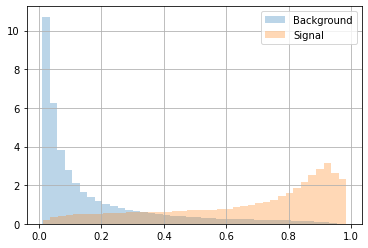

In [23]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)
df[df.Label==0].Prob.hist(label='Background',**kwargs)
df[df.Label==1].Prob.hist(label='Signal',**kwargs)
plt.legend()

In [24]:
# Let's calculate the total weights (yields)
sigall = weight.dot(y)
backall = weight.dot(y == 0)

# The training weights
sigtrain = weight_train.dot(y_train)
backtrain = weight_train.dot(y_train == 0)

# The training weights
sigtest = weight_test.dot(y_test)
backtest = weight_test.dot(y_test == 0)

# aside:  these can also be done by looping instead of using a dot product
#  (Usually vectorized operations are faster for interpreted code)

In [25]:
# Now let's look at event yields that pass our selection
sigtrain_sel = weight_train.dot(y_train & (y_train_prob > pcut))
backtrain_sel = weight_train.dot((y_train == 0) & (y_train_prob > pcut))

sigtest_sel = weight_test.dot(y_test & (y_test_prob > pcut))
backtest_sel = weight_test.dot((y_test == 0) & (y_test_prob > pcut))


In [26]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_corr = sigtrain_sel*sigall/sigtrain
backtrain_sel_corr = backtrain_sel*backall/backtrain

sigtest_sel_corr = sigtest_sel*sigall/sigtest
backtest_sel_corr = backtest_sel*backall/backtest

print(f"Corrected selected yields in training sample, signal = {sigtrain_sel_corr}, background = {backtrain_sel_corr}")
print(f"Corrected selected yields in test sample, signal = {sigtest_sel_corr}, background = {backtest_sel_corr}")


Corrected selected yields in training sample, signal = 224.39118602453723, background = 3128.412252655264
Corrected selected yields in test sample, signal = 220.87210402638422, background = 3754.2276326783485


In [27]:
print("AMS of training sample", ams(sigtrain_sel_corr,backtrain_sel_corr))
print("AMS of test sample", ams(sigtest_sel_corr,backtest_sel_corr))

AMS of training sample 3.9590829350674386
AMS of test sample 3.565631347507362


How did we do? Not too bad. Here are the scores of real submissions.
![Comparison with submissions](data/tr150908_davidRousseau_TMVAFuture_HiggsML.001.png)

This is of course a bit of a simplification from a real physics analysis, where systematics often seem to take the most time. They are ignored here.
![Comparison with real analysis](data/tr140415_davidRousseau_Rome_Higgs_MVA_HiggsML.001.png)

What to work on for the rest of the day:
1. Attempt to calculate the AMS for the logistic regression cases.
1. Do we overfit? Add plots to see.
1. Which variables are important?
1. Should we **[preprocess](http://scikit-learn.org/stable/modules/preprocessing.html)** the input data to be the same scale? Note that we have some -999 values that indicate the variable could not be calculated.
1. We do not use the event weights in the training. Can they help? Note, that you don't want to just apply the weights as is since they will make background dominate over signal.
1. The best scores in the Challenge all used cross-validation; if you have time, try to implement it.

Tomorrow we will continue on this example with neural networks.